In [2]:

import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.cluster import DBSCAN

In [3]:
def find_directions(lines, tolerance=np.pi / 8):
    horizontal = []
    vertical = []
    for line in lines:
        rho, theta = line[0]
        if abs(theta) < tolerance or abs(theta - np.pi) < tolerance:
            vertical.append((rho, theta))
        elif abs(theta - np.pi / 2) < tolerance:
            horizontal.append((rho, theta))
    return horizontal, vertical


def print_line(img, all_lines, no_copy = False, print_theta = False):
    # if no_copy:
    #     copy = img
    # else:
    #     copy = np.copy(img)
    
    copy = np.copy(img)
    h, w = img.shape
    extension = max(w, h)*1.1
    if all_lines is not None:
        for line in all_lines:
            rho, theta = line
            if print_theta:
                deg = theta*180/np.pi
                print(deg)
                print(rho)
            a = math.cos(theta)
            b = math.sin(theta)
            # Punkt najblizszy srodka ukł. wsp.
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + extension*(-b)), int(y0 + extension*(a)))
            pt2 = (int(x0 - extension*(-b)), int(y0 - extension*(a)))
            cv2.line(copy, pt1, pt2, (255,255,255), 3, cv2.LINE_AA) 
        plt.figure(figsize=(5,5))      
        plt.imshow(copy, cmap='gray')
        return copy

In [4]:
checkboard_bgr = cv2.imread("photo/background_checkboard/checkboard2.jpg")
checkboard_rgb = cv2.cvtColor(checkboard_bgr, cv2.COLOR_BGR2RGB)


gray = cv2.cvtColor(checkboard_bgr, cv2.COLOR_BGR2GRAY)

# equalized = cv2.equalizeHist(checkboard)

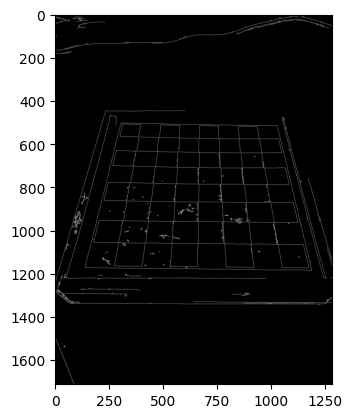

In [5]:
edges = cv2.Canny(gray, 50, 200)
plt.imshow(edges, cmap='gray')

In [6]:
lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
print(lines.shape)
# print_line(checkboard, lines)


(32, 1, 2)


In [7]:
horiz, vert = find_directions(lines)
# print_line(checkboard, horiz)

In [8]:
print(len(horiz))
print(len(vert))

22
10


In [9]:
# print_line(checkboard,vert, True, print_theta=True)

In [10]:
def normalize_vertical(rho, theta, idx): 
    rho = (-1)*rho
    theta = np.pi - theta
    idx = -1
    return rho, theta, idx

def mean_line(lines):
    """Calculate the mean line (rho, theta) from a list of lines."""
    rhos = []
    thetas = []
    norm_lines = []
    for i in range(len(lines)):
        rho, theta = lines[i]
        if np.pi - np.pi / 8 <= theta <= np.pi:
            rho, theta, i = normalize_vertical(rho, theta, i)
        rhos.append(rho)
        thetas.append(theta)
        norm_lines.append(i)
    return [np.mean(rhos), np.mean(thetas)], norm_lines



In [11]:
m_vert, norm_vert = mean_line(vert)
m_horiz, norm_horiz = mean_line(horiz)
  
# print(m_vert)
# print(m_horiz)
# print_line(checkboard,[m_vert])

In [12]:
def intersection_point(line1, line2):
    """Oblicza punkt przecięcia dwóch linii w formie (rho, theta)."""
    rho1, theta1 = line1
    rho2, theta2 = line2
    
    # Wyliczamy współczynniki (a1, b1) i (a2, b2) z równań linii w przestrzeni biegunowej
    a1, b1 = np.cos(theta1), np.sin(theta1)
    a2, b2 = np.cos(theta2), np.sin(theta2)
    
    # Obliczamy wyznacznik
    d = a1 * b2 - a2 * b1
    if np.isclose(d, 0):
        return None  
    
    # Obliczamy współrzędne punktu przecięcia
    x = (rho1 * b2 - rho2 * b1) / d
    y = (rho2 * a1 - rho1 * a2) / d
    return (x, y)



In [13]:
x, y = intersection_point(m_horiz, m_vert)
print(x, y)
# image = cv2.circle(checkboard, (int(x),int(y)), radius=10, color=(0, 0, 255),thickness= -1)
# plt.figure(figsize=(10,10))
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

493.76855 940.9251


In [14]:
def cluster_lines(lines1, lines2, eps=20, min_samples=1):
    # Średnia linia pionowa
    mean_vert, norm_lines = mean_line(lines2)

    # Znajdź punkty przecięcia linii poziomych ze średnią pionową linią
    intersections = []
    for h_line in lines1:
        point = intersection_point(h_line, mean_vert)
    
        if point:
            intersections.append(point)
    
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(intersections)
    labels = db.labels_
    # print(len(labels))
    # print(labels[1])


    clustered_lines = []
    for label in set(labels):
        if label == -1:  
            continue

        cluster = []
        for i in range(len(lines1)):
            if labels[i] == label:
                cluster.append(lines1[i])
        mean_cluster, norm_cluster = mean_line(cluster)
        if norm_cluster[0] == -1:
            mean_cluster[0], mean_cluster[1], _ = normalize_vertical(mean_cluster[0], mean_cluster[1], 0)
        clustered_lines.append(mean_cluster)

    return clustered_lines

9


array([[ 50,  53,  55, ..., 220, 220, 220],
       [ 61,  63,  63, ..., 219, 219, 219],
       [ 67,  68,  68, ..., 219, 219, 219],
       ...,
       [ 22,  28, 190, ..., 168, 168, 168],
       [ 20,  40, 226, ..., 167, 167, 167],
       [ 19,  73, 234, ..., 166, 166, 166]], dtype=uint8)

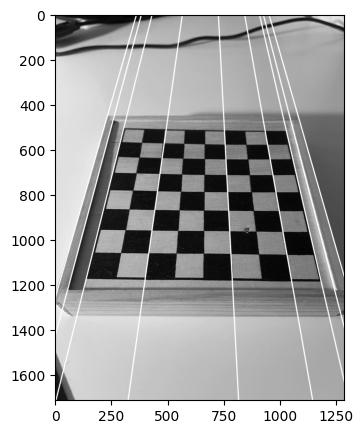

In [15]:
clust_vert = cluster_lines(vert, horiz)
print(len(clust_vert))
print_line(gray, clust_vert, print_theta=False)

11


array([[ 50,  53,  55, ..., 220, 220, 220],
       [ 61,  63,  63, ..., 219, 219, 219],
       [ 67,  68,  68, ..., 219, 219, 219],
       ...,
       [ 22,  22,  22, ..., 168, 168, 168],
       [ 20,  20,  20, ..., 167, 167, 167],
       [ 19,  19,  19, ..., 166, 166, 166]], dtype=uint8)

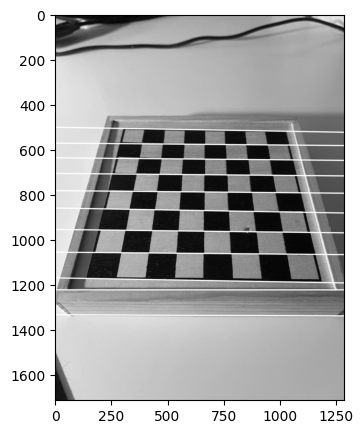

In [16]:
clust_horiz = cluster_lines(horiz, vert)
print(len(clust_horiz))
print_line(gray, clust_horiz, print_theta=False)


99


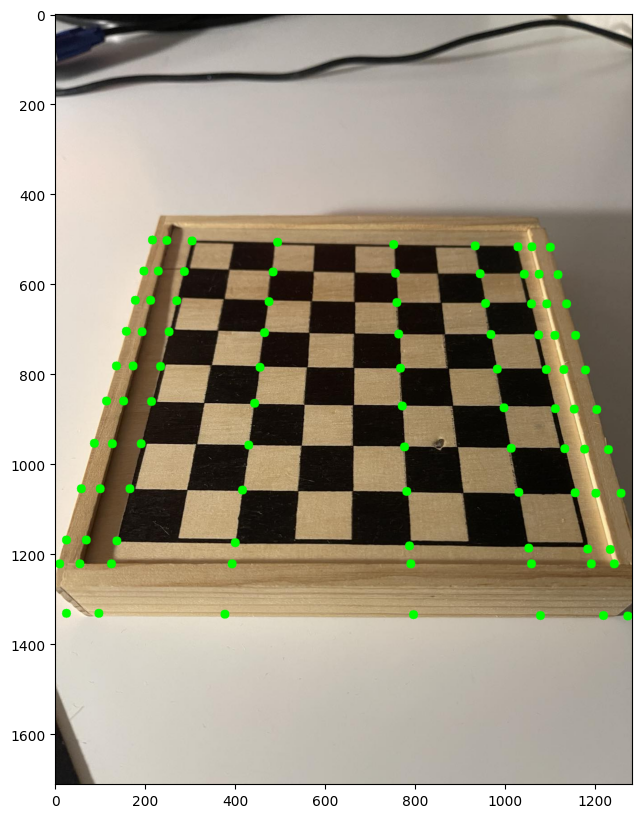

In [111]:
im = checkboard_rgb.copy()
intersections = []
for h in clust_horiz:
    for v in clust_vert:
        x, y = intersection_point(h, v)
        intersections.append((x, y))
        image = cv2.circle(im, (int(x),int(y)), radius=10, color=(0, 255, 0),thickness= -1)
plt.figure(figsize=(10,10))
plt.imshow(image)
print(len(intersections))

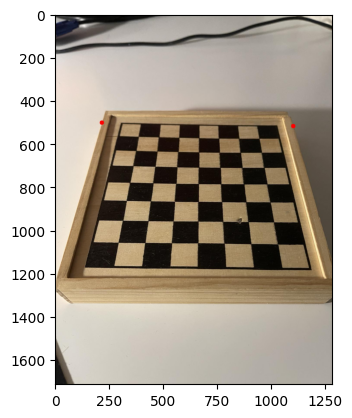

In [18]:
left_top = min(intersections, key=lambda p: p[0] + p[1])  # Najmniejsza suma x + y
right_top = max(intersections, key=lambda p: p[0] - p[1])  # Największa różnica x - y
right_bottom = max(intersections, key=lambda p: p[0] + p[1])  # Największa suma x + y
left_bottom = min(intersections, key=lambda p: p[0] - p[1])  # Najmniejsza różnica x - y

corners = [left_top, right_top, right_bottom, left_bottom]

im = checkboard_rgb.copy()
for x, y in corners:
            image = cv2.circle(im, (int(x),int(y)), radius=10, color=(255, 0, 0),thickness= -1)


plt.imshow(im)



In [19]:

pattern_size=(7,7)
square_size = 100  # Rozmiar pojedynczego kwadratu w pikselach
dstPoints = np.array([
    [0, 0],
    [square_size * pattern_size[0], 0],
    [square_size * pattern_size[0], square_size * pattern_size[1]],
    [0, square_size * pattern_size[1]]
], dtype='float32')

srcPoints = np.array([
    corners[0],  
    corners[1], 
    corners[2], 
    corners[3]  
], dtype='float32')

H, status = cv2.findHomography(srcPoints, dstPoints)


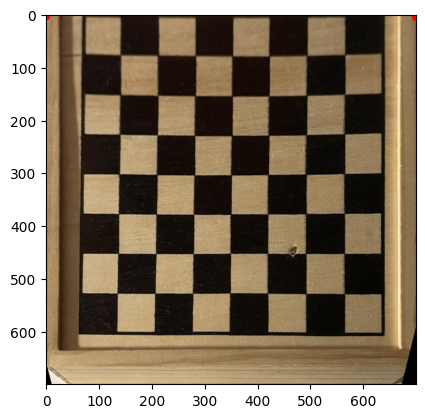

In [20]:
# output_size = (square_size * pattern_size[0], square_size * pattern_size[1])
# 
# # Rzutowanie planszy
# warped_image = cv2.warpPerspective(image, H, output_size)
# 
# # Wyświetlenie wyniku
# plt.imshow(warped_image)


# RANSAC

22


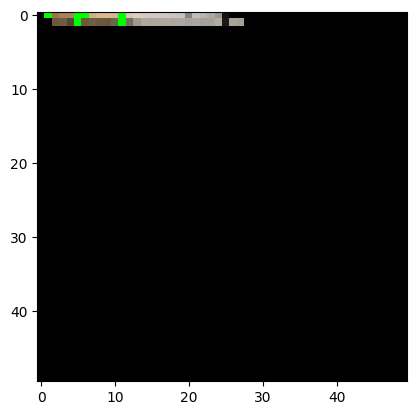

In [110]:
def choose_lines(lines):
    line1 = random.choice(lines)
    line2 = random.choice(lines)
    while line1 == line2:
        line2 = random.choice(lines)
    return line1, line2

def count_inliers(H, intersections, tolerance=0.5):

    intersections_homogeneous = np.hstack((intersections, np.ones((len(intersections), 1))))
    projected = (H @ intersections_homogeneous.T).T
    # print(projected)

    projected /= projected[:, 2].reshape(-1, 1)  # Konwersja do współrzędnych niejednorodnych
    # print("************************")
    # print(projected)
    rounded = np.round(projected[:, :2])
    distances = np.linalg.norm(projected[:, :2] - rounded, axis=1)
    inlier_mask = distances < tolerance
    return np.sum(inlier_mask), projected
def ransac(img, horiz, vert, intersections, tolerance=0.1, best_H = None,
best_inliers = 0):
    # 1 step
    horiz1, horiz2 = choose_lines(horiz)
    vert1, vert2 = choose_lines(vert)
    
    p1 = intersection_point(horiz1, vert1)
    p2 = intersection_point(horiz2, vert1)
    p3 = intersection_point(horiz1, vert2)
    p4 = intersection_point(horiz2, vert2)

    # 2
    for sx in range(1,9):
        for sy in range(1,9):
            srcPoints = np.array([p1, p2, p3, p4])
            dstPoints = np.array([
            [0, 0],  # Lewy górny
            [sx, 0],  # Prawy górny
            [0, sy],  # Lewy dolny
            [sx, sy],  # Prawy dolny
            ], dtype=np.float32)
            
            H, status = cv2.findHomography(srcPoints, dstPoints)
            # dst = cv2.warpPerspective(img, H, (50, 50))
            # plt.imshow(dst)
            # 3
            inliers, _ = count_inliers(H, intersections, tolerance)
            
            if inliers > best_inliers:
                best_inliers = inliers
                best_H = H
            # print(inliers)

    return best_H, best_inliers

# ransac(checkboard_rgb, clust_horiz, clust_vert, 3, 2, intersections, tolerance=0.5)
H, inliers = ransac(checkboard_rgb, clust_horiz, clust_vert, intersections, best_H = None,
best_inliers = 0 )
best_H = None
best_inliers = 0
# while best_inliers > len(intersections)*0.5:
for i in range(1):
            H, inliers = ransac(checkboard_rgb, clust_horiz, clust_vert, intersections, best_H = None,
best_inliers = 0 )
            # if inliers > best_inliers:
            #     best_H = H
            #     best_inliers = inliers
                # b_sx = sx
                # b_sy = sy
dst = cv2.warpPerspective(image, H*100, (50, 50))
plt.imshow(dst)
print(inliers)

In [47]:

# best_H = None
# best_inliers = 0
# while best_inliers < len(intersections)*0.5:
#     for sx in range(1, 9):
#         for sy in range(1, 9):
#             H, inliers, inlier_mask = ransac(checkboard_rgb, clust_horiz, clust_vert, sx, sy, intersections )
#             if inliers > best_inliers:
#                 best_H = H
#                 best_inliers = inliers
#                 best_inliers_mask = np.int_(inlier_mask)
#                 b_sx = sx
#                 b_sy = sy
#                 
# print(best_inliers)
# print(best_H)
# print(b_sx)
# print(b_sy)
# print(best_inliers_mask)

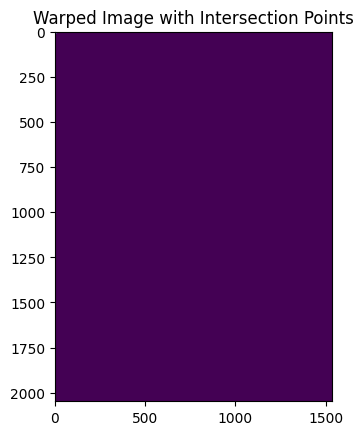

In [85]:
warped_img = cv2.warpPerspective(gray, best_H, (10, 10))

plt.imshow(warped_img)
# plt.scatter(best_inliers_mask[:, 0], best_inliers_mask[:, 1], color='red')  
plt.title("Warped Image with Intersection Points")
plt.show()